In [94]:
import numpy as np
import pandas as pd
import requests
import json
from scipy import stats as st

In [ ]:
import requests
import json


class MakeApiCall:

    def get_data(self, api):
        response = requests.get(f"{api}")
        if response.status_code == 200:
            print("sucessfully fetched the data")
            self.formatted_print(response.json())
        else:
            print(
                f"Hello person, there's a {response.status_code} error with your request")

    def get_user_data(self, api, parameters):
        response = requests.get(f"{api}", headers=parameters)
        if response.status_code == 200:
            print("sucessfully fetched the data with parameters provided")
            self.formatted_print(response.json())
        else:
            print(
                f"Hello person, there's a {response.status_code} error with your request")

    def formatted_print(self, obj):
        text = json.dumps(obj, sort_keys=True, indent=4)
        print(text)

    def __init__(self, api):
         self.get_data(api)

        #parameters = {
            #'Authorization': 'access_token myToken'
        #}
        #self.get_user_data(api, parameters)


Separate SF into tiles w/ lat and long look ups

In [17]:
# SF is about ~15 km x 15 km
# The paper used 2 km x 2 km tiles
# Let's use 100 m x 100 m tile 

import geopy.distance
import math

#longest vertical distance
coords_1 = (37.811262, -122.477010)
coords_2 = (37.708251, -122.477010)

vertical_dist = geopy.distance.geodesic(coords_1, coords_2).m
v_count = math.ceil(vertical_dist / 100)

#longest horizontal distance 
coords_1 = (37.778946, -122.514446)
coords_2 = (37.778946, -122.357110)

horizontal_dist = geopy.distance.geodesic(coords_1, coords_2).m
h_count = math.ceil(horizontal_dist / 100)

In [95]:
# https://code.activestate.com/recipes/577713-midpoint-of-two-gps-points/ 

import math

def midpoint(x1, y1, x2, y2):
#Input values as degrees

#Convert to radians
    lat1 = math.radians(x1)
    lon1 = math.radians(x2)
    lat2 = math.radians(y1)
    lon2 = math.radians(y2)


    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + bx)

    return [round(math.degrees(lat3), 6), round(math.degrees(lon3), 6)]

In [169]:
# If midpoint of tile is in the ocean, exclude
# https://gis.stackexchange.com/questions/235133/checking-if-a-geocoordinate-point-is-land-or-ocean

from mpl_toolkits.basemap import Basemap
bm = Basemap()   # default: projection='cyl'
print (bm.is_land(99.675, 13.104))  #True
print (bm.is_land(100.539, 13.104))  #False

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [140]:
# Make a dataframe with:
# Tile #
# Upper left coordinate
# Upper right
# Lower left
# lower right 
# midpoint 

long_interval = np.linspace(-122.357110, -122.514446, h_count)

lat_interval = np.linspace(37.708251, 37.811262, v_count)

tiles = pd.DataFrame(columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'])

count1 = 0
for lai in range(len(lat_interval) - 1): 
    lat1 = lat_interval[lai]
    lat2 = lat_interval[lai + 1]
    for loi in range(len(long_interval) - 1):
        long1 = long_interval[loi]
        long2 = long_interval[loi + 1]
        mid = midpoint(lat1, long1, lat2, long2)
        #if bm.is_land(mid[0], mid[1]) == True:
           # continue
        t = pd.DataFrame([[count1, lat1, lat2, long1, long2, mid]], columns = ['Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'])
        tiles = pd.concat([tiles, t], ignore_index = True)
        count1 += 1


In [110]:
tiles.head(5)

,Tile_ID,Lat1,Lat2,Long1,Long2,Mid
0,0,37.708251,37.709155,-122.35711,-122.35825,"[-10.111211, 45.733374]"
1,1,37.708251,37.709155,-122.35825,-122.35939,"[-10.110617, 45.733069]"
2,2,37.708251,37.709155,-122.35939,-122.36053,"[-10.110023, 45.732764]"
3,3,37.708251,37.709155,-122.36053,-122.36167,"[-10.10943, 45.732459]"
4,4,37.708251,37.709155,-122.36167,-122.362811,"[-10.108836, 45.732155]"
...,...,...,...,...,...,...
15726,15726,37.810358,37.811262,-122.507605,-122.508745,"[-9.97969, 45.76063]"
15727,15727,37.810358,37.811262,-122.508745,-122.509886,"[-9.979097, 45.760321]"
15728,15728,37.810358,37.811262,-122.509886,-122.511026,"[-9.978504, 45.760012]"
15729,15729,37.810358,37.811262,-122.511026,-122.512166,"[-9.977911, 45.759703]"


Split street characterstics into tiles

Split historical and future collision data into tiles

In [136]:
collisions = pd.read_csv(r'.\Data\transbase_collisions_02112023.csv')
collisions.head(5)

#collisions.columns

# dataset is from 2017 - September 30 2022
# Historical Group: Oct 1 2018 - September 30 2020
# Future Group: Oct 1 2020 - September 30 2022

collisions['Historical'] = np.where((collisions['collision_date'] >= 20181001) & (collisions['collision_date'] <= 20200930),1,0)

collisions['Future'] = np.where((collisions['collision_date'] >= 20201001) & (collisions['collision_date'] <= 20220930),1,0)

collisions.head(5)

,type,geometry,case_id_pkey,collision_severity,accident_year,collision_date,collision_time,distance,direction,pcf_viol_category,...,bndy_type,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,Historical,Future
0,Feature,[object Object],17045414,Injury (Complaint of Pain),2017,20171227,1849.0,0,Not Stated,Unknown,...,Geographic Boundary,1.0,Driver,South,Proceeding Straight,Driver,East,Proceeding Straight,0,0
1,Feature,[object Object],170800277,Injury (Complaint of Pain),2017,20171001,145.0,28,South,Unsafe speed for prevailing conditions,...,Geographic Boundary,1.0,Driver,North,Proceeding Straight,Driver,North,Making Left Turn,0,0
2,Feature,[object Object],170800299,Injury (Other Visible),2017,20171001,233.0,0,Not Stated,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,East,Making Left Turn,Driver,South,Proceeding Straight,0,0
3,Feature,[object Object],170801106,Injury (Other Visible),2017,20171001,1228.0,99,East,Violation of right-of-way - left turn,...,Geographic Boundary,1.0,Driver,West,Making U Turn,Bicyclist,West,Proceeding Straight,0,0
4,Feature,[object Object],170801225,Injury (Complaint of Pain),2017,20171001,1300.0,210,North,Opening door on traffic side when unsafe,...,Geographic Boundary,1.0,Other,South,Stopped In Road,Driver,South,Passing Other Vehicle,0,0


In [165]:
# adding historical and future collisions to data frame

# 'Tile_ID', 'Lat1', 'Lat2', 'Long1', 'Long2', 'Mid'
collisions = collisions[(collisions['Future'] == 1) | (collisions['Historical'] == 1)]
collisions_f = collisions[collisions['Future'] == 1]
collisions_h = collisions[collisions['Historical'] == 1]
# for every tile, sum the future and historical collisions 
# the collision should take place within the tile 
fut = []
his = []
for i in range(len(tiles)):
    ti = tiles.iloc[i]
    lat1 = ti['Lat1']
    lat2 = ti['Lat2']
    long1 = ti['Long1']
    long2 = ti['Long2']
    f = len(collisions_f[(collisions_f['latitude'] < lat2) & (collisions_f['latitude'] > lat1) & (collisions_f['longitude'] > long2) & (collisions_f['longitude'] < long1)])
    h = len(collisions_h[(collisions_h['latitude'] < lat2) & (collisions_h['latitude'] > lat1) & (collisions_h['longitude'] > long2) & (collisions_h['longitude'] < long1)])
    fut = np.append(fut,f)
    his = np.append(his,h)

In [166]:
tiles['Future'] = fut
tiles['Historical'] = his

Scrape data and create model that takes inputs of satellite images or OSM files

Split into training and test

In [188]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(tiles[['Historical', 'Lat1','Lat2']], 
                                   tiles['Future'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

Train model

In [224]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# x: lat, long, historical
# y: future 

def create_linear_model():

    input = tf.keras.layers.Input(shape=(3,))
    
    #input_t = tf.data.Dataset.from_tensor_slices(input.to_dict(orient="list"))

    normalized = layers.Normalization(input_shape=[3,], axis=None)(input)

   #x = normalizer(input_t)

    outputs = layers.Dense(1, activation = 'relu')(normalized)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error',
        metrics = [tf.keras.metrics.Accuracy()])
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    np.asarray(x_train).astype('float32'),
    y_train,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3)]               0         
                                                                 
 normalization_21 (Normaliza  (None, 3)                3         
 tion)                                                           
                                                                 
 dense_20 (Dense)            (None, 1)                 4         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________
Epoch 1/10
315/315 [==============================] - 1s 3ms/step - loss: 4.1059 - accuracy: 0.3427 - val_loss: 0.3393 - val_accuracy: 0.8677
Epoch 2/10
315/315 [==============================] - 1s 2ms/step - loss: 0.3041 - accuracy: 0.7826 - val_loss: 0.29

In [221]:
import matplotlib
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error/Accuracy')
    plt.legend()
    plt.grid(True)

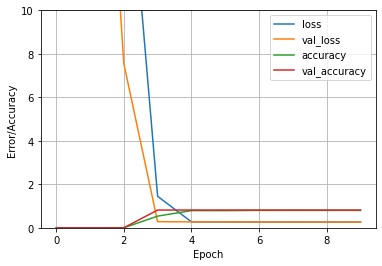

In [222]:
plot_loss(history)

Test model

Model actual future collisions

Create dashboard featuring future hotspots